<h1>
<center>CFRM 421/521, Spring 2023</center>
</h1>

<h1>
<center>Ziwen Chen</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Tuesday, April 29, 2024, 11:59 PM**


* Total marks: 45


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [14 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/105167110/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import os
from random import random
from tkinter.tix import X_REGION

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sympy.abc import alpha

data = pd.read_csv ("datasets_HW2/NYSE.csv")
data

/var/folders/p5/gv35v2wx4m7fndc0tw1bvpwm0000gn/T/ipykernel_20709/754114170.py:3: DeprecationWarning: The Tix Tk extension is unmaintained, and the tkinter.tix wrapper module is deprecated in favor of tkinter.ttk
  from tkinter.tix import X_REGION


,date,day_of_week,DJ_return,log_volume,log_volatility,train
0,1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1,1962-12-04,tues,0.007813,0.346202,-11.749305,True
2,1962-12-05,wed,0.003845,0.525306,-11.665609,True
3,1962-12-06,thur,-0.003462,0.210182,-11.626772,True
4,1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...,...
6046,1986-12-24,wed,0.006514,-0.236104,-9.807366,False
6047,1986-12-26,fri,0.001825,-1.322425,-9.906025,False
6048,1986-12-29,mon,-0.009515,-0.371237,-9.827660,False
6049,1986-12-30,tues,-0.001837,-0.385638,-9.926091,False


## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**Solution:**

In [2]:
import numpy as np


def Create_Sequences (data, steps):
    data = data[["DJ_return", "log_volume", "log_volatility"]].copy ()
    X = []
    y = []
    for i in range (len (data) - steps):
        X.append (data.iloc[i:i + steps])
        y.append (data.iloc[i + steps]["log_volume"])

    return np.array (X), np.array (y)


X, y = Create_Sequences (data, steps=5)

In [3]:
X[:3]

array([[[-4.46100000e-03,  3.25730000e-02, -1.31274026e+01],
        [ 7.81300000e-03,  3.46202000e-01, -1.17493047e+01],
        [ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01]],

       [[ 7.81300000e-03,  3.46202000e-01, -1.17493047e+01],
        [ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01],
        [-1.08240000e-02,  1.33246000e-01, -1.08725263e+01]],

       [[ 3.84500000e-03,  5.25306000e-01, -1.16656090e+01],
        [-3.46200000e-03,  2.10182000e-01, -1.16267724e+01],
        [ 5.68000000e-04,  4.41870000e-02, -1.17281302e+01],
        [-1.08240000e-02,  1.33246000e-01, -1.08725263e+01],
        [ 1.24000000e-04, -1.15280000e-02, -1.09777968e+01]]])

In [4]:
y[:3]

array([ 0.133246, -0.011528,  0.001607])

## (b)  [5 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV split, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  200, 400, 600, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=1,3,5,7$. When tuning hyperparameters on the validation sets, fit the model only on a random 10% sample of the instances of the training set on the same CV fold to reduce computational time (that is, use the same reduced training set for all the hyperparameters, but a different one for each CV fold). Note this will still preserve the correct time ordering, and the reduce training set should not be used when fitting and evaluating the best model on the test set. The performance measure is RMSE. Report the best hyperparameters.

**Solution:**

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score

In [6]:
# n_total = X.shape[0]
# 
# train_end = int (0.8 * n_total)
# val_end = int (0.9 * n_total)
# 
# # Train: [0, train_end)
# X_train = X[:train_end]
# y_train = y[:train_end]
# 
# # Validation: [train_end, val_end)
# X_val = X[train_end:val_end]
# y_val = y[train_end:val_end]
# 
# # Test: [val_end, end)
# X_test = X[val_end:]
# y_test = y[val_end:]

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split (X_test, y_test, test_size=0.5, random_state=42)

In [7]:
# Optional: print their shapes
print ("Train:", X_train.shape)
print ("Val:  ", X_val.shape)
print ("Test: ", X_test.shape)


Train: (4836, 5, 3)
Val:   (605, 5, 3)
Test:  (605, 5, 3)


In [8]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'ccp_alpha': [10 ** (-k) for k in [1, 3, 5, 7]]
}

In [9]:
n_train = len (X_train)
n_val = len (X_val)
n_reduced_train = max (1, int (0.1 * n_train))  # 10% from training set

# randomly select 10% from training set
X_train_reduced_idx = np.random.choice (np.arange (n_train), size=n_reduced_train, replace=False)
X_train_reduced = X_train[X_train_reduced_idx]
X_train_reduced = X_train_reduced.reshape (X_train_reduced.shape[0], -1)

y_train_reduced = y_train[X_train_reduced_idx]


In [10]:
# cv_split = []
# 
# for i in range(3):
#     # 每折都从原始训练集中抽 10%
#     # randomly draw 10% from X_train for each fold
#     n_reduced_train = max(1, int(0.1 * n_train))
#     reduced_train_idx = np.random.choice(np.arange(n_train), size=n_reduced_train, replace=False)
# 
#     # 验证集索引是固定的：在拼接后位于训练集之后
#     val_idx = np.arange(n_train, n_total)
# 
#     # 合并 train+val 索引
#     cv_split.append((reduced_train_idx, val_idx))

In [11]:
# # Set up grid search
# grid_search = GridSearchCV (
#     estimator=RandomForestRegressor (random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     n_jobs=-1
# )

X_val_2d = X_val.reshape (X_val.shape[0], -1)

# 记录每组参数在X_val上的表现
results = []

kf = KFold (n_splits=3, shuffle=True, random_state=42)

# custom grid search, validate on X_val only
for a in param_grid['ccp_alpha']:
    for n_estimator in param_grid['n_estimators']:
        val_preds = []
        for train_index, _ in kf.split (X_train_reduced):
            X_fold_train = X_train_reduced[train_index]
            y_fold_train = y_train_reduced[train_index]

            rf = RandomForestRegressor (n_estimators=n_estimator, ccp_alpha=a, random_state=42, n_jobs=-1)
            rf.fit (X_fold_train, y_fold_train)

            # 始终在 X_val 上评估
            y_val_pred = rf.predict (X_val_2d)
            val_preds.append (y_val_pred)

        # 对3次在 X_val 上预测结果做投票 or 平均准确率
        mse = np.mean ([mean_squared_error (y_val, pred) for pred in val_preds])
        results.append (((a, n_estimator), np.sqrt (mse)))

In [12]:
# grid_search.fit (X_train_reduced, y_train_reduced)
# 
# # Best hyperparameters
# best_params = grid_search.best_params_
# print ("Best hyperparameters:", best_params)

# 找出最小的 RMSE（或 MSE）
best_params, best_score = min (results, key=lambda x: x[1])

print (f"Best params: ccp_alpha={best_params[0]}, n_estimators={best_params[1]}")
print (f"Validation RMSE: {best_score:.4f}")

Best params: ccp_alpha=1e-05, n_estimators=600
Validation RMSE: 0.1753


## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

**Solution**:

In [13]:
X_train_2d = X_train.reshape (X_train.shape[0], -1)

final_model = RandomForestRegressor (ccp_alpha=1e-05, n_estimators=600, random_state=42, n_jobs=-1)
final_model.fit (X_train_2d, y_train)

RandomForestRegressor(ccp_alpha=1e-05, n_estimators=600, n_jobs=-1,
                      random_state=42)

In [14]:
# Evaluate on test
X_test_2d = X_test.reshape (X_test.shape[0], -1)

y_pred = final_model.predict (X_test_2d)
test_mse = mean_squared_error (y_test, y_pred)
print ("Test RMSE:", np.sqrt (test_mse))

Test RMSE: 0.16664109712670222


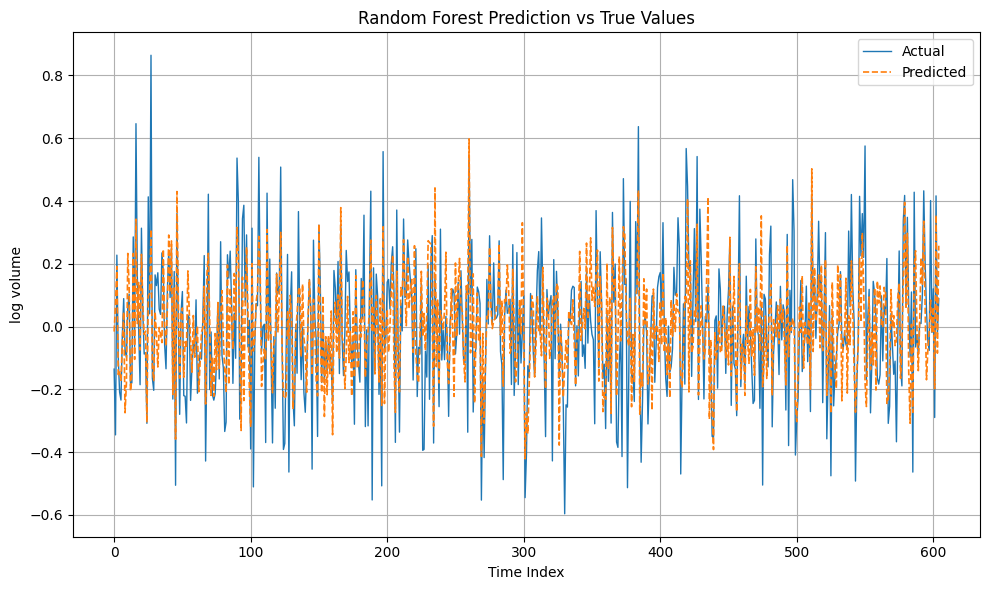

In [15]:
import matplotlib.pyplot as plt

plt.figure (figsize=(10, 6))  # 设置图像大小

plt.plot (y_test, label='Actual', linewidth=1)
plt.plot (y_pred, label='Predicted', linestyle='--', linewidth=1.2)

plt.title ('Random Forest Prediction vs True Values')
plt.xlabel ('Time Index')
plt.ylabel ('log volume')
plt.legend ()
plt.grid (True)
plt.tight_layout ()
plt.show ()

## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. On the test set, compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

**Solution**:

In [16]:
X_simple, y_simple = Create_Sequences (data, steps=1)

X_simple = X_simple.reshape (X_simple.shape[0], -1)

train_end_simple = int (0.8 * len (X_simple))
X_train_s = X_simple[:train_end_simple]
y_train_s = y_simple[:train_end_simple]
X_test_s = X_simple[train_end_simple:]
y_test_s = y_simple[train_end_simple:]

In [17]:
rf_simple = RandomForestRegressor (ccp_alpha=1e-05, n_estimators=600, random_state=42, n_jobs=-1)
rf_simple.fit (X_train_s, y_train_s)

RandomForestRegressor(ccp_alpha=1e-05, n_estimators=600, n_jobs=-1,
                      random_state=42)

In [18]:
rf_simple_pred = rf_simple.predict (X_test_s)
mse = mean_squared_error (y_test_s, rf_simple_pred)
print ("Test RMSE:", np.sqrt (mse))

Test RMSE: 0.21425881653400142


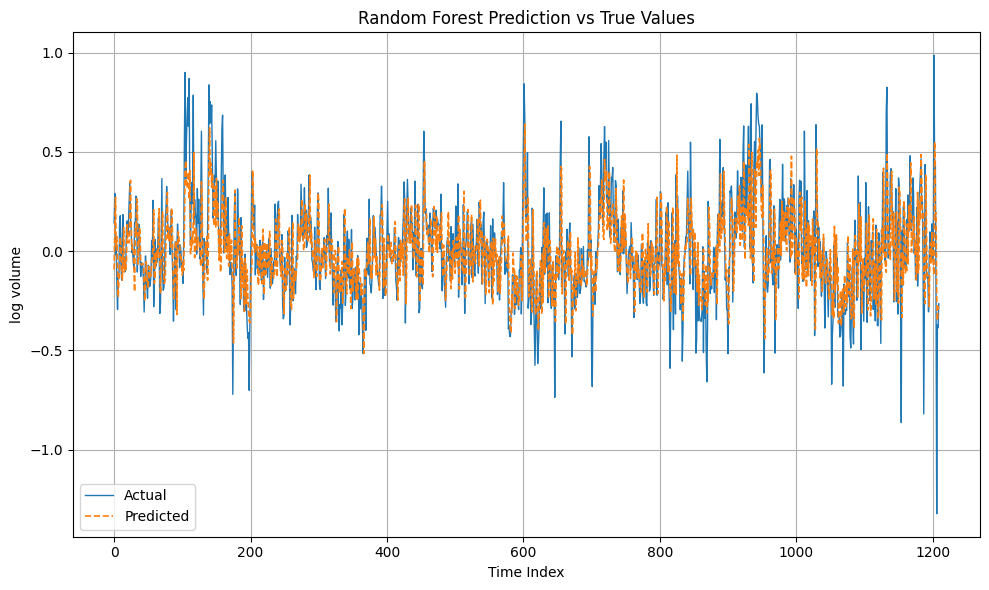

In [19]:
plt.figure (figsize=(10, 6))  # 设置图像大小

plt.plot (y_test_s, label='Actual', linewidth=1)
plt.plot (rf_simple_pred, label='Predicted', linestyle='--', linewidth=1.2)

plt.title ('Random Forest Prediction vs True Values')
plt.xlabel ('Time Index')
plt.ylabel ('log volume')
plt.legend ()
plt.grid (True)
plt.tight_layout ()
plt.show ()

## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

**Solution:**

In [139]:
base_features = ["DJ_return", "log_volume", "log_volatility"]
timesteps = 5

column_names = [f"{feat}_t-{t}" for t in range (timesteps, 0, -1) for feat in base_features]

print ("Assuming t is the time we want to predict:")
for score, name in zip (final_model.feature_importances_, column_names):
    print (round (score, 2), name)

Assuming t is the time we want to predict:
0.03 DJ_return_t-5
0.06 log_volume_t-5
0.02 log_volatility_t-5
0.03 DJ_return_t-4
0.06 log_volume_t-4
0.01 log_volatility_t-4
0.04 DJ_return_t-3
0.04 log_volume_t-3
0.01 log_volatility_t-3
0.04 DJ_return_t-2
0.04 log_volume_t-2
0.01 log_volatility_t-2
0.07 DJ_return_t-1
0.52 log_volume_t-1
0.01 log_volatility_t-1


***The most important feature*** is the most recent log_volume, and the value is 0.52 !

# 2. SVM classification and regression [11 marks]

For all SVM models in this question use a standard scaler.

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) (2nd edition) on the textbook website may help with this question.

In [21]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

mnist = fetch_openml ('mnist_784', as_frame=False, cache=True, parser='auto')
X_train = mnist["data"][:60000]
X_test = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test = mnist["target"][60000:]

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

N = 2000
split_obj = StratifiedShuffleSplit (n_splits=1,
                                    test_size=N / 60000, random_state=42)
for other_idx, subsample_idx in split_obj.split (X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

stdScaler = StandardScaler ()
X_transformed = stdScaler.fit_transform (X)

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

**Solution:**

In [23]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'C': [10 ** (-k) for k in range (10)]
}

In [24]:
grid_search = GridSearchCV (
    estimator=LinearSVC (max_iter=50000, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

In [25]:
# 拟合模型
grid_search.fit (X_transformed, y)
print (f"Best Params: {grid_search.best_params_}, Accuracy: {grid_search.best_score_}")

Best Params: {'C': 0.01}, Accuracy: 0.8284896590743668


## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` from `scipy.stats.loguniform` with 10 random samples. The `loguniform(a,b)` function takes a random sample from the probability distribution with pdf $f(x)\propto 1/x, x\in[a,b]$. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

**Solution:**

In [26]:
from scipy.stats import uniform, loguniform
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [27]:
param_dis = {
    'C': uniform (1, 10),
    'gamma': loguniform (0.0001, 0.1),
}

In [28]:
rd_search = RandomizedSearchCV (
    estimator=SVC (kernel='rbf', max_iter=50000, random_state=42),
    param_distributions=param_dis,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

In [29]:
rd_search.fit (X_transformed, y)
print (f"Best Params: {rd_search.best_params_}, Accuracy: {rd_search.best_score_}")

Best Params: {'C': np.float64(10.261386432193476), 'gamma': np.float64(0.0002581834658246224)}, Accuracy: 0.8964976970973972


## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

In [30]:
best_model = SVC (kernel='rbf', **rd_search.best_params_, max_iter=50000, random_state=42)
best_model.fit (X_transformed, y)

SVC(C=np.float64(10.261386432193476), gamma=np.float64(0.0002581834658246224),
    max_iter=50000, random_state=42)

In [31]:
X_test_transformed = stdScaler.transform (X_test)

y_pred = best_model.predict (X_test_transformed)

In [32]:
from sklearn.metrics import accuracy_score

acc = accuracy_score (y_test, y_pred)
print ("Accuracy:", acc)

Accuracy: 0.9081


## (d) [3 marks]

Consider the original source of the California housing data (which is different from the modified dataset used in Homework 1) in Scikit-Learn. The data is obtained and split using the code below. The training set is stored in `X_train` and `y_train`. Do not shuffle the data.

Hint: Reading the solution to Question 11 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb) (3rd edition) on the textbook website may help with this question.

In [33]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing ()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,20)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` with 20 random samples. To save training time, use only the first 2000 instances of `X_train` and `y_train` (which have been randomly shuffled already) for the search. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

**Solution:**

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [35]:
X_train_2k = X_train[:2000]
y_train_2k = y_train[:2000]

std_scaler = StandardScaler ()
X_train_scaled = std_scaler.fit_transform (X_train_2k)

In [36]:
param_dis = {
    'C': uniform (1, 20),
    'gamma': loguniform (0.0001, 0.1),
}

In [37]:
# rbf
random_search_rbf = RandomizedSearchCV (
    estimator=SVR (kernel='rbf', max_iter=50000),
    param_distributions=param_dis,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
)

In [38]:
random_search_rbf.fit (X_train_scaled, y_train_2k)

RandomizedSearchCV(cv=3, estimator=SVR(max_iter=50000), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x122cde930>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x130e4d6d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [39]:
print (f"Best Params:{random_search_rbf.best_params_}, MSE: {-random_search_rbf.best_score_}")

Best Params:{'C': np.float64(8.49080237694725), 'gamma': np.float64(0.07114476009343425)}, MSE: 0.31702561590585215


In [40]:
# sigmoid
random_search_sigmoid = RandomizedSearchCV (
    estimator=SVR (kernel='sigmoid', max_iter=50000),
    param_distributions=param_dis,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
)

In [41]:
random_search_sigmoid.fit (X_train_scaled, y_train_2k)

RandomizedSearchCV(cv=3, estimator=SVR(kernel='sigmoid', max_iter=50000),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x122cde930>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x130e4d6d0>},
                   scoring='neg_mean_squared_error')

In [42]:
print (f"Best Params:{random_search_sigmoid.best_params_}, MSE: {-random_search_sigmoid.best_score_}")

Best Params:{'C': np.float64(16.70412759689333), 'gamma': np.float64(0.0011203820862845334)}, MSE: 0.470001460779449


## (e) [2 marks]

**Task:** Choose the best model in (d). But now refit it on the full training set (not just the first 2000 instances). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
std_scaler = StandardScaler ()
X_train_scaled = std_scaler.fit_transform (X_train)
X_test_scaled = std_scaler.transform (X_test)

In [45]:
best_model = SVR (kernel='rbf', **random_search_rbf.best_params_)
best_model.fit (X_train_scaled, y_train)

SVR(C=np.float64(8.49080237694725), gamma=np.float64(0.07114476009343425))

In [46]:
y_pred = best_model.predict (X_test_scaled)
mse = mean_squared_error (y_test, y_pred)

In [140]:
print ("Test set RMSE:", np.sqrt (mse))

Test set RMSE: 0.5919289983019433


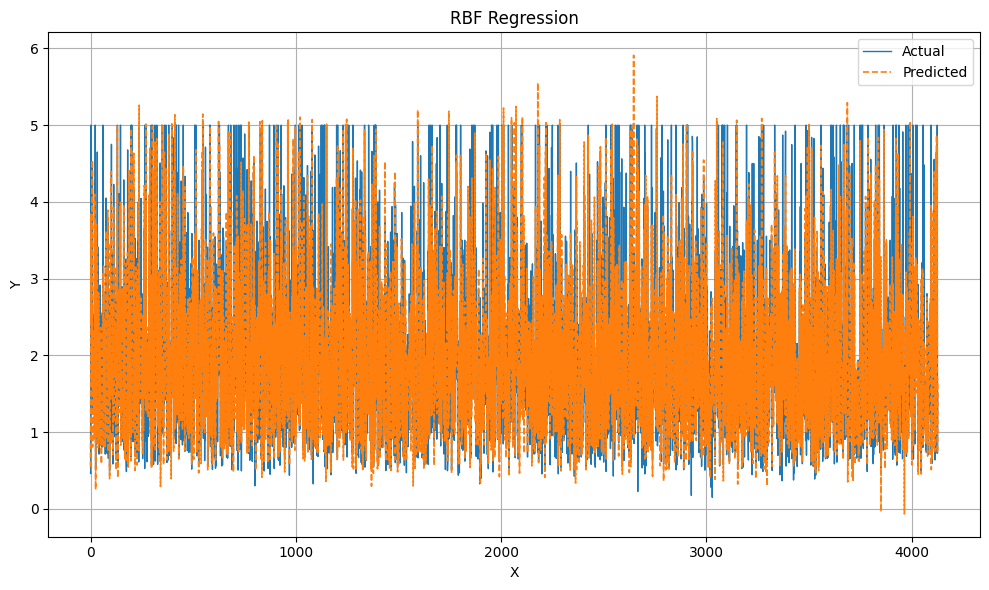

In [48]:
plt.figure (figsize=(10, 6))  # 设置图像大小

plt.plot (y_test, label='Actual', linewidth=1)
plt.plot (y_pred, label='Predicted', linestyle='--', linewidth=1.2)

plt.title ('RBF Regression')
plt.xlabel ('X')
plt.ylabel ('Y')
plt.legend ()
plt.grid (True)
plt.tight_layout ()
plt.show ()

# 3. Voting classifiers [11 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, after spliting into a training, validation and test set, we keep only the first 5000 instances of the training set, and only the first 1000 instances of the validation and test set, as given by the following code.

In [49]:
N = 50_000
M = 60_000
X_train = mnist["data"][:N][:5000]
y_train = mnist["target"][:N][:5000]
X_valid = mnist["data"][N:M][:1000]
y_valid = mnist["target"][N:M][:1000]
X_test = mnist["data"][M:][:1000]
y_test = mnist["target"][M:][:1000]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a multilayer perceptron classifier using the class `MLPClassifier()` from `sklearn.neural_network` with arguments `random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier  with arguments  `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

Hint: Reading the solution to Question 8 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

**Solution:**

In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [51]:
# mlp
mlp = MLPClassifier (random_state=42)
mlp.fit (X_train, y_train)

MLPClassifier(random_state=42)

In [52]:
y_pred_val = mlp.predict (X_valid)
score_mlp = accuracy_score (y_valid, y_pred_val)
print (f"MLP: {score_mlp}")

MLP: 0.879


In [53]:
etc = ExtraTreesClassifier (random_state=42, n_estimators=100, n_jobs=-1)
etc.fit (X_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [54]:
y_pred_val = etc.predict (X_valid)
score_etc = accuracy_score (y_valid, y_pred_val)
print (f"ExtraTree: {score_etc}")

ExtraTree: 0.948


In [55]:
# adaBoost
adaBst = AdaBoostClassifier (n_estimators=50, random_state=42, learning_rate=0.2)
adaBst.fit (X_train, y_train)

AdaBoostClassifier(learning_rate=0.2, random_state=42)

In [141]:
y_pred_val = adaBst.predict (X_valid)
score_adaBst = accuracy_score (y_valid, y_pred_val)
print (f"ADABoost: {score_adaBst}")

ADABoost: 0.431


In [57]:
# GBst
gbst = GradientBoostingClassifier (n_estimators=10, random_state=42, learning_rate=0.25, max_depth=2)
gbst.fit (X_train, y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, n_estimators=10,
                           random_state=42)

In [58]:
y_pred_val = gbst.predict (X_valid)
score_gbst = accuracy_score (y_valid, y_pred_val)
print (f"GradientBoost: {score_gbst}")

GradientBoost: 0.802


## (b)  [5 marks]

Train the following models:

* a hard-voting ensemble classifier for all the models in (a)
* a soft-voting ensemble classifier for all the models in (a)
* a hard-voting ensemble classifier dropping the worst performing model in (a)
* a soft-voting ensemble classifier dropping the worst performing model in (a)

Evaluate the accuracy of these voting classifiers on the validation set, and compare it to the performance of the individual models in (a).

**Solution:**

In [145]:
from sklearn.ensemble import VotingClassifier

# hard vote
vote_clf_hard = VotingClassifier (
    estimators=[('mlp', MLPClassifier (random_state=42)),
                ('etc', ExtraTreesClassifier (random_state=42, n_estimators=100, n_jobs=-1)),
                ('adaBst', AdaBoostClassifier (n_estimators=50, random_state=42, learning_rate=0.2)),
                ('gbst', GradientBoostingClassifier (n_estimators=10, random_state=42, learning_rate=0.25, max_depth=2)), 
                ],
    voting='hard'
)

vote_clf_hard.fit (X_train, y_train)

VotingClassifier(estimators=[('mlp', MLPClassifier(random_state=42)),
                             ('etc',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('adaBst',
                              AdaBoostClassifier(learning_rate=0.2,
                                                 random_state=42)),
                             ('gbst',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=10,
                                                         random_state=42))])

In [146]:
y_pred_val = vote_clf_hard.predict (X_valid)
score_hard = accuracy_score (y_valid, y_pred_val)
print (f"hard vote for all models {score_hard}")

hard vote for all models 0.897


In [147]:
vote_clf_hard.set_params(adaBst="drop")
vote_clf_hard.fit (X_train, y_train)
y_pred_val = vote_clf_hard.predict (X_valid)
score_hard_drop = accuracy_score (y_valid, y_pred_val)
print (f"hard vote for all models, lowest dropped {score_hard_drop}")

hard vote for all models, lowest dropped 0.911


In [148]:
# soft vote
vote_clf_soft = VotingClassifier (
    estimators=[('mlp', MLPClassifier (random_state=42)),
                ('etc', ExtraTreesClassifier (random_state=42, n_estimators=100, n_jobs=-1)),
                ('adaBst', AdaBoostClassifier (n_estimators=50, random_state=42, learning_rate=0.2)),
                ('gbst', GradientBoostingClassifier (n_estimators=10, random_state=42, learning_rate=0.25, max_depth=2)), 
                ],
    voting='soft'
)

vote_clf_soft.fit (X_train, y_train)

VotingClassifier(estimators=[('mlp', MLPClassifier(random_state=42)),
                             ('etc',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('adaBst',
                              AdaBoostClassifier(learning_rate=0.2,
                                                 random_state=42)),
                             ('gbst',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=10,
                                                         random_state=42))],
                 voting='soft')

In [149]:
# soft vote
y_pred_val = vote_clf_soft.predict (X_valid)
score_soft = accuracy_score (y_valid, y_pred_val)
print (f"soft vote for all models {score_soft}")

soft vote for all models 0.885


In [150]:
# soft vote, drop lowest
vote_clf_soft.set_params(adaBst="drop")
vote_clf_soft.fit (X_train, y_train)
y_pred_val = vote_clf_soft.predict (X_valid)
score_soft_drop = accuracy_score (y_valid, y_pred_val)
print (f"hard vote for all models, lowest dropped {score_soft_drop}")

hard vote for all models, lowest dropped 0.885


## (c)  [2 marks]

Of the four voting classifiers in (b), choose the best model. Then evaluate the accuracy of this model on the test set.

**Solution:**

In [151]:
vote_clf_hard_drop = VotingClassifier (
    estimators=[('mlp', MLPClassifier (random_state=42)),
                ('etc', ExtraTreesClassifier (random_state=42, n_estimators=100, n_jobs=-1)),
                ('adaBst', AdaBoostClassifier (n_estimators=50, random_state=42, learning_rate=0.2)),
                ('gbst', GradientBoostingClassifier (n_estimators=10, random_state=42, learning_rate=0.25, max_depth=2)), 
                ],
    voting='hard'
)
vote_clf_hard_drop.set_params(adaBst="drop")

vote_clf_hard_drop.fit (X_train, y_train)

VotingClassifier(estimators=[('mlp', MLPClassifier(random_state=42)),
                             ('etc',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('adaBst', 'drop'),
                             ('gbst',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=10,
                                                         random_state=42))])

In [152]:
best_model = vote_clf_hard_drop
y_pred_test = best_model.predict (X_test)
score_test = accuracy_score (y_test, y_pred_test)
print (f"Test Accuracy of the best model: {score_test}")

Test Accuracy of the best model: 0.907


# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

**Solution:**

In [153]:
from sklearn.model_selection import cross_val_predict

# cross val predict
y_cross_pred_mlp = cross_val_predict(mlp, X_train, y_train, cv=3)
y_cross_pred_etc = cross_val_predict(etc, X_train, y_train, cv=3)
y_cross_pred_adaBst = cross_val_predict(adaBst, X_train, y_train, cv=3)
y_cross_pred_gbst = cross_val_predict(gbst, X_train, y_train, cv=3)

In [154]:
print (f"mlp cross val predict: {y_cross_pred_mlp[:5]}")
print (f"etc cross val predict: {y_cross_pred_etc[:5]}")
print (f"adaBst cross val predict: {y_cross_pred_adaBst[:5]}")
print (f"gbst cross val predict: {y_cross_pred_gbst[:5]}")

mlp cross val predict: ['5' '0' '4' '1' '9']
etc cross val predict: ['5' '0' '4' '1' '9']
adaBst cross val predict: ['0' '0' '7' '1' '4']
gbst cross val predict: ['3' '0' '4' '1' '9']


In [157]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

cat_pipline = make_pipeline(
    OneHotEncoder(categories='auto', handle_unknown='ignore'),
)

# transform the data, only fit on y_train
y_train_hot = cat_pipline.fit_transform(y_train.reshape(-1,1)).toarray()

y_cross_pred_mlp_hot = cat_pipline.transform(y_cross_pred_mlp.reshape(-1, 1))
y_cross_pred_etc_hot = cat_pipline.transform(y_cross_pred_etc.reshape(-1, 1))
y_cross_pred_adaBst_hot = cat_pipline.transform(y_cross_pred_adaBst.reshape(-1, 1))
y_cross_pred_gbst_hot = cat_pipline.transform(y_cross_pred_gbst.reshape(-1, 1))

In [158]:
print (f"mlp cross val predict:\n {y_cross_pred_mlp_hot[:5].toarray()}")
print (f"etc cross val predict:\n {y_cross_pred_etc_hot[:5].toarray()}")
print (f"adaBst cross val predict:\n {y_cross_pred_adaBst_hot[:5].toarray()}")
print (f"gbst cross val predict:\n {y_cross_pred_gbst_hot[:5].toarray()}")

mlp cross val predict:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
etc cross val predict:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
adaBst cross val predict:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
gbst cross val predict:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

**Solution:**

In [159]:
# concatenate 4 predictions ---> (5000, num_features)
X_train_hot = np.concatenate([y_cross_pred_mlp_hot.toarray(), y_cross_pred_etc_hot.toarray(), y_cross_pred_adaBst_hot.toarray(), y_cross_pred_gbst_hot.toarray()], axis=1) # become the train dataset

In [160]:
from sklearn.ensemble import RandomForestClassifier

rd_blender = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rd_blender.fit(X_train_hot, y_train_hot)

RandomForestClassifier(n_jobs=-1, random_state=42)

## (c) [3 marks]

Obtain the predictions of the blender on the test set by feeding predictions on the test set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the test set and compare this to the results in Question 3(c).

**Solution:**

In [161]:
y_pred_mlp = mlp.predict (X_test).reshape(-1,1)
y_pred_etc = etc.predict (X_test).reshape(-1,1)
y_pred_adaBst = adaBst.predict (X_test).reshape(-1,1)
y_pred_gbst = gbst.predict (X_test).reshape(-1,1)


y_test_hot = cat_pipline.transform(y_test.reshape(-1,1)).toarray()

y_pred_mlp_hot = cat_pipline.transform(y_pred_mlp).toarray()
y_pred_etc_hot = cat_pipline.transform(y_pred_etc).toarray()
y_pred_adaBst_hot = cat_pipline.transform(y_pred_adaBst).toarray()
y_pred_gbst_hot = cat_pipline.transform(y_pred_gbst).toarray()

In [162]:
print (f"mlp val predict:\n {y_pred_mlp_hot[:5]}")
print (f"etc val predict:\n {y_pred_etc_hot[:5]}")
print (f"adaBst val predict:\n {y_pred_adaBst_hot[:5]}")
print (f"gbst val predict:\n {y_pred_gbst_hot[:5]}")

mlp val predict:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
etc val predict:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
adaBst val predict:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
gbst val predict:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [163]:
X_test_hot = np.concatenate([y_pred_mlp_hot, y_pred_etc_hot, y_pred_adaBst_hot, y_pred_gbst_hot], axis=1)

In [164]:
acc = rd_blender.score(X_test_hot, y_test_hot)

print (f"the blender has the accuracy: {acc}, which is higher than the result of 3c")

the blender has the accuracy: 0.918, which is higher than the result of 3c
